# Boxplot of DE junctions

In [1]:
library(ggpubr)
library(ggplot2)
library(tidyverse)
suppressMessages(library(data.table))

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
ggplot_save <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


subset_deg <- function(fn, thres){
    jt = fread(fn) %>% rename(Feature='V1') %>% 
        filter(adj.P.Val < thres) %>% 
        select(Feature, ensemblID, Symbol, logFC, adj.P.Val)
    return(jt)
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Load DEG annotation

In [3]:
fn1 = '../../_m/junctions/diffExpr_interaction_full.txt'
fn2 = '../../_m/junctions/diffExpr_maleVfemale_full.txt'
fn3 = '../../_m/junctions/diffExpr_szVctl_full.txt'
juncs = subset_deg(fn1, 0.05)
sex = subset_deg(fn2, 1)
sz = subset_deg(fn3, 1)

In [4]:
df = juncs %>% 
        inner_join(sex, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Sex")) %>%
        inner_join(sz, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Diagnosis"))
df = add_symnum(df)
df

Feature,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr21:8401487-8445715(-),,,6.462429,1.977227e-06,-0.6900338,0.6942432277,-5.678082,1.604291e-07,2.0e-06,****
chr21:8401417-8445654(-),,,3.818954,2.615920e-05,-0.2414791,0.8587578544,-3.391430,5.096574e-06,2.6e-05,****
chr14:49566087-49586737(+),,,-4.428507,1.286513e-04,1.9490009,0.0817815065,3.941279,1.692828e-06,0.00013,***
chr21:8401395-8445553(-),,,5.809398,3.625764e-04,0.5161015,0.7977351468,-6.709044,4.327267e-09,0.00036,***
chr21:8401970-8446050(+),,,6.047697,6.728559e-04,-3.4592450,0.0000182977,-4.198279,2.650014e-02,0.00067,***
chrM:2246-2357(+),,,3.699453,6.038357e-03,-2.3247420,0.0002794120,-1.826557,4.371144e-01,0.00604,**
chr2:132254419-132255143(+),,,-3.425367,3.939449e-02,1.7834593,0.1036638285,1.755929,4.941152e-01,0.03939,*


## Load phenotypes

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv'
pheno = fread(pheno_file) %>% column_to_rownames(var='V1') %>% 
    mutate_if(is.character, as.factor)
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R10424,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL
R12195,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,SZ


## Load residualized expression

In [6]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf = fread(res_file) %>% 
    column_to_rownames(var="V1") %>% t
resdf = as.data.frame(resdf) %>% 
    rownames_to_column() %>% 
    rename(RNum=rowname) %>% 
    select(RNum, df$Feature)
resdf[1:2, 1:3]

Warning message in fread(res_file):
“Detected 359 column names but the data has 360 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,RNum,chr21:8401487-8445715(-),chr21:8401417-8445654(-)
,<chr>,<dbl>,<dbl>
1,R10424,0.1357274,-0.02991936
2,R12195,-0.8260069,-1.15152280


## Merge data

In [7]:
jj = pheno %>% 
    inner_join(resdf, by='RNum')
jj$Dx = fct_drop(jj$Dx)
jj %>% dim
jj[1:2, 1:10]

[1] 359  15

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,chr21:8401487-8445715(-),chr21:8401417-8445654(-)
,<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,0.1357274,-0.02991936
2,Br5073,R12195,DLPFC,8.4,62.61,Male,AA,SZ,-0.8260069,-1.15152280


In [8]:
dft = jj %>% pivot_longer(-c(BrNum, RNum, Region, RIN, Age, Sex, Race, Dx), 
                          names_to="Feature", values_to="Res") %>% 
    inner_join(df, by="Feature") %>% mutate_at("Feature", as.factor)
dft[1:2, 1:10]

BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,Feature,Res
<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>
Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,chr21:8401487-8445715(-),0.13572739
Br5168,R10424,DLPFC,6.7,64.08,Male,CAUC,CTL,chr21:8401417-8445654(-),-0.02991936


Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


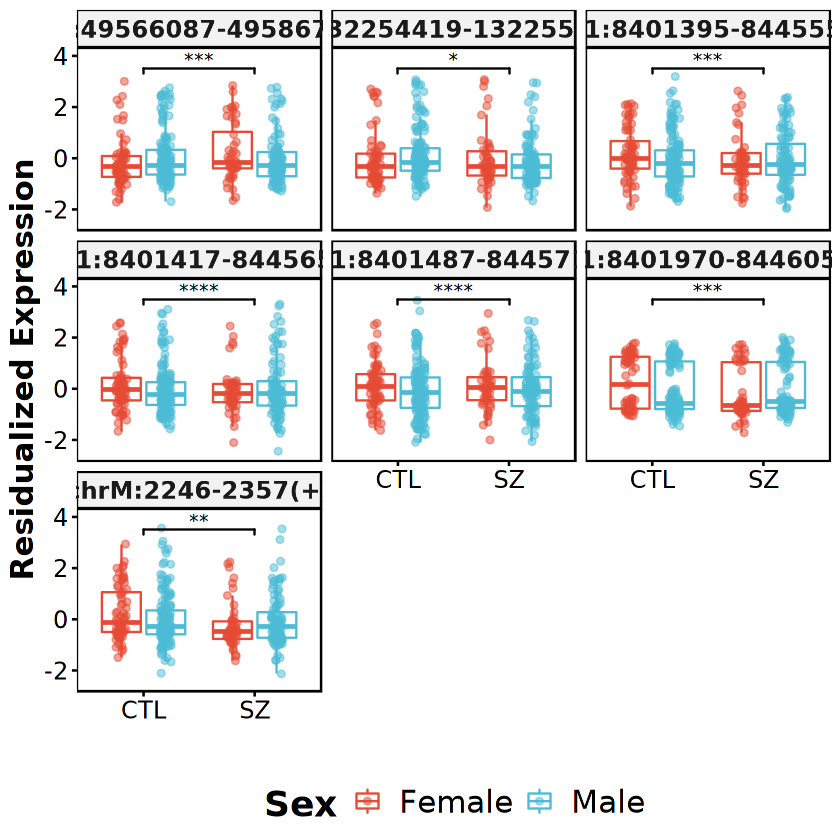

In [9]:
tmp = df %>% mutate(group1='CTL', group2='SZ', y_pos=3.5)

bxp <- ggboxplot(dft, x="Dx", y="Res", color="Sex", add='jitter',
                 panel.labs.font=list(face='bold', size = 14),
                 facet.by=c("Feature"), palette="npg", xlab='', 
                 ylim=c(-2.5, 4), ylab='Residualized Expression', 
                 add.params=list(alpha=0.5), legend="bottom", 
                 outlier.shape=NA) +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, 
                        annotations=p.signif, y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=18, face="bold") + font("xy.text", size=14) + 
        font("legend.title", size=21, face="bold") + font("legend.text", size=18)
         
bxp

In [10]:
ggplot_save(bxp, 'junc_interaction', 10, 9)

## Session Info

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-15 20:38:12 EDT"

   user  system elapsed 
 24.413  18.587  21.605 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-15                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 